<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>CET Template Notebook</b> <br>
Contact author(s): <i>Sarah Greenstreet</i> <br>
Last verified to run: <i>2024-03-05</i> <br>
LSST Science Pipelines version: Weekly <i>2024_04</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

**Description:** _An introduction to near-Earth objects (NEOs) in the DP0.3 dataset, including illustrations of the four NEOs sub-populations: Amors, Apollos, Atens, and Atiras._

**Skills:** _Use TAP queries to retrieve Solar System objects. Plot properties and orbits of near-Earth objects._

**LSST Data Products:** _TAP DP0.3 MPCORB (10-year) and SSObject tables._

**Packages:** _lsst.rsp.get_tap_service_

**Credit:**
_Originally developed by Sarah Greenstreet and the Rubin Community Science Team in the context of the Rubin DP0._

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

_This tutorial demonstrates how to use TAP to query the MPCORB and SSObject tables. The tables are queried simultaneously and joined on their SSObjectId. The properties of near-Earth objects (NEOs; perihelia $q$<1.3 au) from the DP0.3 catalogs are examined. The NEOs in this sample are restricted to those with semimajor axes $a$<4.0 au, and eccentricities $e$<1.0. The orbital properties of NEOs are examined, including plotting the planet-crossing regions and boundaries that define the four NEO sub-populations: Amors, Apollos, Atens, and Atiras._

### 1.1 NEO Dynamical Classes

**Amors** have orbits exterior to Earth's orbit with perihelia 1.017 au < $q$ < 1.3 au (i.e., Amors are always farther from the Sun than Earth).

**Apollos** are on Earth-crossing orbits with semimajor axis $a$ > 1.0 au and perihelion $q$ < 1.017 au (i.e., Apollos are Earth-crossers with orbits larger than Earth's orbit).

**Atens** are on Earth-crossing orbits with semimajor axis $a$ < 1.0 au and aphelion $Q$ > 0.983 au (i.e., Atens are Earth-crossers with orbits smaller than Earth's orbit).

**Atiras** have orbits interior to Earth's orbit with aphelion $Q$ < 0.983 au (i.e., Atiras are always closer to the Sun than Earth).

_INCLUDE A SCHEMATIC OF 4 SUB-POP ORBITS._

### 1.2 Package Imports

The `matplotlib` and `numpy` libraries are widely used Python libraries for plotting and scientific computing. We will use these packages below, including the matplotlib.pyplot plotting sublibrary.

We also use the `lsst.rsp` package to access the TAP service and query the DP0 catalogs.

In [1]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# LSST package for TAP queries
from lsst.rsp import get_tap_service

### 1.3 Define Functions and Parameters

#### 1.3.1 Define functions for computing orbital parameters not included in the MPCORB table

Define a function to convert a given perihelion distance ($q$) and eccentricity ($e$) to an orbital semimajor axis ($a$). Their relationship is defined by $q=a*(1−e)$.

In [2]:
def calc_semimajor_axis(q, e):
    """
    Given a perihelion distance and orbital eccentricity,
    calculate the semi-major axis of the orbit.

    Parameters
    ----------
    q: ndarray
        Distance at perihelion, in au.
    e: ndarray
        Orbital eccentricity.

    Returns
    -------
    a: ndarray
        Semi-major axis of the orbit, in au.
        q = a(1-e), so a = q/(1-e)
    """

    return q / (1.0 - e)

Define a function to convert a given perihelion distance ($q$) and eccentricity ($e$) to an aphelion distance ($Q$). Their relationships are defined by: $Q=q*(1+e)/(1-e)$.

In [3]:
def calc_aphelion(q, e):
    """
    Given a perihelion distance and orbital eccentricity,
    calculate the semi-major axis of the orbit.

    Parameters
    ----------
    q: ndarray
        Distance at perihelion, in au.
    e: ndarray
        Orbital eccentricity.

    Returns
    -------
    Q: ndarray
        Distance at aphelion, in au.
        Q = q*(1+e)/(1-e)
    """
    
    return q * (1.0 + e) / (1.0 - e)

#### 1.3.2 Define functions to return arrays needed for plotting planet-crossing curves on an ($a$, $e$) plot

Define a function to return an array with ($a$, $e$) values needed to plot a curve showing the aphelion at a planet's perihelion.

In [15]:
def get_aphelion_at_planets_perihelion_curve_values(q_planet):
    
    a_Q = np.arange(0.001, q_planet, 0.001)
    e_Q = (q_planet / a_Q) - 1.0
        
    return (a_Q, e_Q)

Define a function to return an array with ($a$, $e$) values needed to plot a curve showing the perihelion at a planet's aphelion.

In [16]:
def get_perihelion_at_planets_aphelion_curve_values(Q_planet):
        
    a_q = np.arange(Q_planet, 4.0, 0.001)
    e_q = (1.0 - (Q_planet / a_q))

    return (a_q, e_q)

Define the perihelia and aphelia for the terrestrial planets and the perihelion boundary for NEOs.

In [6]:
q_Earth = 0.983
Q_Earth = 1.017

q_Mercury = 0.307
Q_Mercury = 0.467

q_Venus = 0.718
Q_Venus = 0.728

q_Mars = 1.381
Q_Mars = 1.666

q_NEOs = 1.3

Set some plotting defaults to make plots look nice.

In [7]:
plt.style.use('tableau-colorblind10')
%matplotlib inline

params = {'axes.labelsize': 15,
          'font.size': 15,
          'legend.fontsize': 10,
          'xtick.major.width': 2,
          'xtick.minor.width': 1,
          'xtick.major.size': 6,
          'xtick.minor.size': 3,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 2,
          'axes.linewidth': 2,
          'axes.labelweight': 1,
          'axes.titleweight': 1,
          'ytick.major.width': 1,
          'ytick.minor.width': 2,
          'ytick.major.size': 6,
          'ytick.minor.size': 3,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [6, 6],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

## 2. Section Heading

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 2.1 Section Sub-heading

#### 2.1.1 Section Sub-sub-heading

## 2. Orbital Parameters of Near-Earth Objects (NEOs)

### 2.1 Query the DP0.3 catalogs to create a table of NEOs and their orbital parameters

Get an instance of the Rubin TAP service client, and assert that it exists.

In [8]:
service = get_tap_service("ssotap")
assert service is not None

Query the DP0.3 catalogs, joining the MPCORB and SSObject tables on their ssObjectId. Limit the query to select sources in the MPCORB table with perihelia $q$ < 1.3 au, eccentricities $e$ < 1, and semimajor axes $a$ < 4 au to get only near-Earth objects, excluding interstellar objects with $e$ > 1 or $a$ < 0.

Define the table returned by this query as "uniqueNEOs" since it contains the IDs of unique solar system objects.

In [9]:
q_select = '1.3'
e_select = '1.0'
a_select = '4.0'

query = """
SELECT
    mpc.ssObjectId, mpc.mpcDesignation,
    mpc.e, mpc.q, mpc.incl
FROM
    dp03_catalogs_10yr.MPCORB as mpc
INNER JOIN dp03_catalogs_10yr.SSObject as sso
ON mpc.ssObjectId = sso.ssObjectId
WHERE mpc.q < {} AND mpc.e < {} AND mpc.q/(1.0-mpc.e) < {} ORDER by mpc.mpcDesignation
""".format(q_select, e_select, a_select)

uniqueNEOs = service.search(query).to_table().to_pandas()

Calculate the semimajor axis $a$ of each object's orbit, using the function defined above, and add it as a column to the `uniqueNEOs` table.

In [10]:
a = calc_semimajor_axis(uniqueNEOs['q'], uniqueNEOs['e'])
uniqueNEOs['a'] = a

Then use the function defined above to calculate the aphelion distance $Q$ of each object's orbit and add it as a column to the `uniqueNEOs` table.

In [11]:
Q = calc_aphelion(uniqueNEOs['q'], uniqueNEOs['e'])
uniqueNEOs['Q'] = Q

Print the `uniqueNEOs` table.

In [12]:
uniqueNEOs

,ssObjectId,mpcDesignation,e,q,incl,a,Q
0,3351269693330531197,1929 SH,0.396081,1.123543,8.450610,1.860420,2.597297
1,-5234750409166262016,1932 EA1,0.435987,1.080947,11.883250,1.916528,2.752110
2,7991128850154218427,1936 CA,0.763999,0.441069,1.321700,1.868924,3.296779
3,-7789613295760699323,1937 UB,0.623179,0.622294,6.067580,1.651432,2.680570
4,8551587316774204226,1947 XC,0.712520,0.625595,2.521620,2.176135,3.726674
...,...,...,...,...,...,...,...
39465,-3152111153344676727,iso00020,0.912171,0.069097,155.764145,0.786725,1.504354
39466,-5397621441865963928,iso00026,0.921228,0.072821,109.157257,0.924457,1.776092
39467,4406479866270187902,iso00075,0.975119,0.087357,22.231391,3.510922,6.934487
39468,7151227162020825803,iso00094,0.967251,0.085642,48.439490,2.615082,5.144522


### 2.2 Create semimajor axis $a$ versus eccentricity $e$ plots of the four dynamical sub-populations of NEOs

Plot the semimajor axis versus eccentricity of all NEOs in the `uniqueNEOs` table.

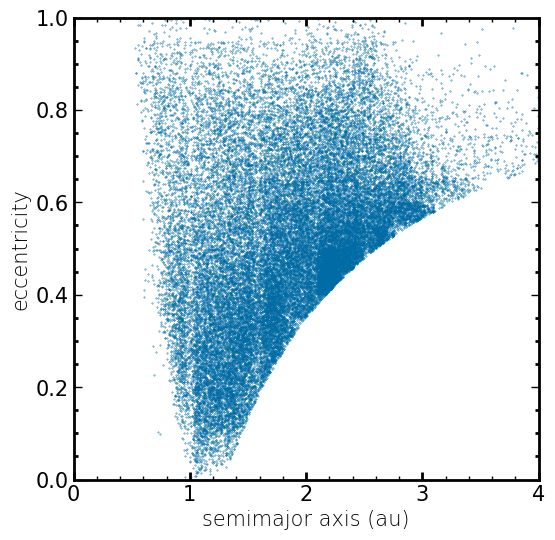

In [14]:
fig, ax = plt.subplots()

plt.xlim([0.,4.])
plt.ylim([0.,1.])
ax.scatter(uniqueNEOs.a, uniqueNEOs.e, s=0.1)
ax.set_xlabel('semimajor axis (au)')
ax.set_ylabel('eccentricity')
ax.minorticks_on()

plt.show()

### Compute the values needed to plot the curves denoting Earth-crossing space

#### Get the Earth-crossing curve values and the NEO region boundary curve values

In order to show the boundaries for the four NEO sub-populations (Amors, Apollos, Atens, and Atiras), arrays of ($a$, $e$) values along the Earth's perihelion and aphelion distances are needed along with those for the $q$ < 1.3 au NEO boundary.

In [ ]:
a_Q_Earth, e_Q_Earth = get_aphelion_at_planets_perihelion_curve_values(q_Earth)

a_q_Earth, e_q_Earth = get_perihelion_at_planets_aphelion_curve_values(Q_Earth)

a_q_NEO, e_q_NEO = get_perihelion_at_planets_aphelion_curve_values(q_NEOs)

#### Plot the two Earth-crossing curves and label NEO class regions

In [ ]:
fig, ax = plt.subplots()
plt.xlim([0.,4.])
plt.ylim([0.,1.])
ax.scatter(uniqueNEOs.a, uniqueNEOs.e, s=0.1)
ax.axvline(x=1.0, color="blue")
ax.plot(a_Q_Earth, e_Q_Earth, "blue")
ax.plot(a_q_Earth, e_q_Earth, "blue")
ax.plot(a_q_NEO, e_q_NEO, "black", linewidth=3)
ax.annotate('Amors', xy=(2.25, 0.5), xytext=(2.25, 0.5), rotation=30.0, weight='bold')
ax.annotate('Apollos', xy=(1.45, 0.75), xytext=(1.45, 0.75), weight='bold')
ax.annotate('Atens', xy=(0.7, 0.6), xytext=(0.7, 0.6), rotation=270.0, weight='bold')
ax.annotate('Atiras', xy=(0.3, 0.5), xytext=(0.3, 0.5), rotation=280.0, weight='bold')
ax.minorticks_on()
plt.xlabel("semimajor axis (au)")
plt.ylabel("eccentricity")
plt.title("NEO Class Boundaries")
plt.show()

#### Determine the percentage of NEOs in each class (Amors, Apollos, Atens, & Atiras)

In [ ]:
Amor_params = (uniqueNEOs.q < q_NEOs) & (uniqueNEOs.q > Q_Earth)

Apollo_params = (uniqueNEOs.q < Q_Earth) & (uniqueNEOs.a > 1.0)

Aten_params = (uniqueNEOs.Q > q_Earth) & (uniqueNEOs.a < 1.0)

Atira_params = (uniqueNEOs.Q < q_Earth)

total_NEOs = len(uniqueNEOs[Amor_params] + uniqueNEOs[Apollo_params] + uniqueNEOs[Aten_params] + uniqueNEOs[Atira_params])

assert total_NEOs == 39470

In [ ]:
fig, ax = plt.subplots()
plt.xlim([0.,4.])
plt.ylim([0.,1.])
ax.scatter(uniqueNEOs[Amor_params].a, uniqueNEOs[Amor_params].e, s=0.1, color='red')
ax.scatter(uniqueNEOs[Apollo_params].a, uniqueNEOs[Apollo_params].e, s=0.1, color='green')
ax.scatter(uniqueNEOs[Aten_params].a, uniqueNEOs[Aten_params].e, s=0.1, color='orange')
ax.scatter(uniqueNEOs[Atira_params].a, uniqueNEOs[Atira_params].e, s=0.25, color='purple')
ax.plot(a_Q_Earth, e_Q_Earth, "blue")
ax.plot(a_q_Earth, e_q_Earth, "blue")
ax.axvline(x=1.0, color="blue")
ax.plot(a_q_NEO, e_q_NEO, "black", linewidth=5)
ax.annotate('Amors', xy=(2.25, 0.5), xytext=(2.25, 0.5), rotation=30.0, weight='bold')
ax.annotate('Apollos', xy=(1.45, 0.75), xytext=(1.45, 0.75), weight='bold')
ax.annotate('Atens', xy=(0.7, 0.6), xytext=(0.7, 0.6), rotation=270.0, weight='bold')
ax.annotate('Atiras', xy=(0.3, 0.5), xytext=(0.3, 0.5), rotation=280.0, weight='bold')
ax.minorticks_on()
plt.xlabel("semimajor axis (au)")
plt.ylabel("eccentricity")
plt.title("NEOs in DP0.3")
plt.show()

In [ ]:
fig, ax = plt.subplots()

plt.xlim([0.,4.])
plt.ylim([0.,1.])

ax.hexbin(uniqueNEOs.a, uniqueNEOs.e,
              gridsize=(int(4.2/0.02), 50), cmap='Spectral_r', bins='log',
              extent=(0, 4.2, 0, 1))
ax.plot(a_Q_Earth, e_Q_Earth, "blue")
ax.plot(a_q_Earth, e_q_Earth, "blue")
ax.axvline(x=1.0, color="blue")
ax.plot(a_q_NEO, e_q_NEO, "black", linewidth=5)
ax.annotate('Amors', xy=(2.25, 0.5), xytext=(2.25, 0.5), rotation=30.0, weight='bold')
ax.annotate('Apollos', xy=(1.45, 0.75), xytext=(1.45, 0.75), weight='bold')
ax.annotate('Atens', xy=(0.7, 0.6), xytext=(0.7, 0.6), rotation=270.0, weight='bold')
ax.annotate('Atiras', xy=(0.3, 0.5), xytext=(0.3, 0.5), rotation=280.0, weight='bold')
ax.set_ylabel('eccentricity')
ax.set_xlabel('semimajor axis (au)')
ax.minorticks_on()

plt.show()

In [ ]:
perc_Amors = len(uniqueNEOs[Amor_params]) / total_NEOs * 100.
perc_Apollos = len(uniqueNEOs[Apollo_params]) / total_NEOs * 100.
perc_Atens = len(uniqueNEOs[Aten_params]) / total_NEOs * 100.
perc_Atiras = len(uniqueNEOs[Atira_params]) / total_NEOs * 100.

print("Percentage of NEOs that are Amors: ", "%4.1f" % (perc_Amors), "%")
print("Percentage of NEOs that are Apollos: ", "%4.1f" % (perc_Apollos), "%")
print("Percentage of NEOs that are Atens: ", "%4.1f" % (perc_Atens), "%")
print("Percentage of NEOs that are Atiras: ", "%4.1f" % (perc_Atiras), "%")

#### Get the planet-crossing curve values for all the terrestrial planets

In [ ]:
a_Q_Mercury, e_Q_Mercury = get_aphelion_at_planets_perihelion_curve_values(q_Mercury)
a_q_Mercury, e_q_Mercury = get_perihelion_at_planets_aphelion_curve_values(Q_Mercury)

a_Q_Venus, e_Q_Venus = get_aphelion_at_planets_perihelion_curve_values(q_Venus)
a_q_Venus, e_q_Venus = get_perihelion_at_planets_aphelion_curve_values(Q_Venus)

a_Q_Earth, e_Q_Earth = get_aphelion_at_planets_perihelion_curve_values(q_Earth)
a_q_Earth, e_q_Earth = get_perihelion_at_planets_aphelion_curve_values(Q_Earth)

a_Q_Mars, e_Q_Mars = get_aphelion_at_planets_perihelion_curve_values(q_Mars)
a_q_Mars, e_q_Mars = get_perihelion_at_planets_aphelion_curve_values(Q_Mars)

In [ ]:
fig, ax = plt.subplots()
plt.xlim([0.,4.])
plt.ylim([0.,1.])
#ax.scatter(uniqueNEOs.a, uniqueNEOs.e, s=0.1)
ax.plot(a_Q_Mercury, e_Q_Mercury, "green", label="Mercury-crossing")
ax.plot(a_q_Mercury, e_q_Mercury, "green")
ax.plot(a_Q_Venus, e_Q_Venus, "orange", label="Venus-crossing")
ax.plot(a_q_Venus, e_q_Venus, "orange")
ax.plot(a_Q_Earth, e_Q_Earth, "blue", label="Earth-crossing")
ax.plot(a_q_Earth, e_q_Earth, "blue")
ax.plot(a_Q_Mars, e_Q_Mars, "red", label="Mars-crossing")
ax.plot(a_q_Mars, e_q_Mars, "red")
ax.minorticks_on()
ax.legend()
plt.xlabel("semimajor axis (au)")
plt.ylabel("eccentricity")
plt.title("Terrestrial Planet-Crossing Regions for NEOs")
plt.show()

In [ ]:
Earth_crossing = (uniqueNEOs.q < Q_Earth) & (uniqueNEOs.Q > q_Earth)

Mercury_crossing = (uniqueNEOs.q < Q_Mercury) & (uniqueNEOs.Q > q_Mercury)

Venus_crossing = (uniqueNEOs.q < Q_Venus) & (uniqueNEOs.Q > q_Venus)

Mars_crossing = (uniqueNEOs.q < Q_Mars) & (uniqueNEOs.Q > q_Mars)

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Planet-Crossing NEOs in DP0.3')

axs[0,0].set_xlim([0.,4.])
axs[0,0].set_ylim([0.,1.])
axs[0,0].scatter(uniqueNEOs[Mercury_crossing].a, uniqueNEOs[Mercury_crossing].e, s=0.1, color='cyan')
axs[0,0].plot(a_Q_Mercury, e_Q_Mercury, "green")
axs[0,0].plot(a_q_Mercury, e_q_Mercury, "green")
axs[0,0].plot(a_q_NEO, e_q_NEO, "black", linewidth=2)
axs[0,0].set_title('Mercury-crossing NEOs')
axs[0,0].minorticks_on()

axs[0,1].set_xlim([0.,4.])
axs[0,1].set_ylim([0.,1.])
axs[0,1].scatter(uniqueNEOs[Venus_crossing].a, uniqueNEOs[Venus_crossing].e, s=0.1, color='cyan')
axs[0,1].plot(a_Q_Venus, e_Q_Venus, "orange")
axs[0,1].plot(a_q_Venus, e_q_Venus, "orange")
axs[0,1].plot(a_q_NEO, e_q_NEO, "black", linewidth=2)
axs[0,1].set_title('Venus-crossing NEOs')
axs[0,1].minorticks_on()

axs[1,0].set_xlim([0.,4.])
axs[1,0].set_ylim([0.,1.])
axs[1,0].scatter(uniqueNEOs[Earth_crossing].a, uniqueNEOs[Earth_crossing].e, s=0.1, color='cyan')
axs[1,0].plot(a_Q_Earth, e_Q_Earth, "blue")
axs[1,0].plot(a_q_Earth, e_q_Earth, "blue")
axs[1,0].plot(a_q_NEO, e_q_NEO, "black", linewidth=2)
axs[1,0].set_title('Earth-crossing NEOs')
axs[1,0].minorticks_on()
axs[1,0].xaxis.set_tick_params(labelbottom=False)

axs[1,1].set_xlim([0.,4.])
axs[1,1].set_ylim([0.,1.])
axs[1,1].scatter(uniqueNEOs[Mars_crossing].a, uniqueNEOs[Mars_crossing].e, s=0.1, color='cyan')
axs[1,1].plot(a_Q_Mars, e_Q_Mars, "red")
axs[1,1].plot(a_q_Mars, e_q_Mars, "red")
axs[1,1].plot(a_q_NEO, e_q_NEO, "black", linewidth=2)
axs[1,1].set_title('Mars-crossing NEOs')
axs[1,1].minorticks_on()
axs[1,1].xaxis.set_tick_params(labelbottom=False)

for ax in axs.flat:
    ax.set(xlabel='semimajor axis (au)', ylabel='eccentricity')
for ax in axs.flat:
    ax.label_outer()
plt.show()

#### Determine the percentage of NEOs that are Earth-, Mars-, Venus-, and Mercury-crossing

In [ ]:
perc_Earth_crossing_NEOs = len(uniqueNEOs[Earth_crossing]) / total_NEOs * 100.
perc_Venus_crossing_NEOs = len(uniqueNEOs[Venus_crossing]) / total_NEOs * 100.
perc_Mercury_crossing_NEOs = len(uniqueNEOs[Mercury_crossing]) / total_NEOs * 100.
perc_Mars_crossing_NEOs = len(uniqueNEOs[Mars_crossing]) / total_NEOs * 100.

print("Fraction of NEOs that are Mercury-crossing: ", "%4.1f" % (perc_Mercury_crossing_NEOs), "%")
print("Fraction of NEOs that are Venus-crossing: ", "%4.1f" % (perc_Venus_crossing_NEOs), "%")
print("Fraction of NEOs that are Earth-crossing: ", "%4.1f" % (perc_Earth_crossing_NEOs), "%")
print("Fraction of NEOs that are Mars-crossing: ", "%4.1f" % (perc_Mars_crossing_NEOs), "%")

In [ ]:
Venus_AND_Earth_crossing = (uniqueNEOs.q < Q_Venus) & (uniqueNEOs.Q > q_Earth)

Mercury_AND_Venus_AND_Earth_AND_Mars_crossing = (uniqueNEOs.q < Q_Mercury) & (uniqueNEOs.Q > q_Mars)

In [ ]:
perc_Venus_AND_Earth_crossing_NEOs = len(uniqueNEOs[Venus_AND_Earth_crossing]) / total_NEOs * 100.
perc_Mercury_AND_Venus_AND_Earth_AND_Mars_crossing_NEOs = len(uniqueNEOs[Mercury_AND_Venus_AND_Earth_AND_Mars_crossing]) / total_NEOs * 100.

print("Fraction of NEOs that are Venus- and Earth-crossing: ", "%4.1f" % (perc_Venus_AND_Earth_crossing_NEOs), "%")
print("Fraction of NEOs that are Mercury- and Venus- and Earth- and Mars-crossing: ", "%4.1f" % (perc_Mercury_AND_Venus_AND_Earth_AND_Mars_crossing_NEOs), "%")

In [ ]:
fig, ax = plt.subplots()
plt.xlim([0.,4.])
plt.ylim([0.,1.])
ax.scatter(uniqueNEOs[Venus_AND_Earth_crossing].a, uniqueNEOs[Venus_AND_Earth_crossing].e, s=0.1)
ax.plot(a_Q_Mercury, e_Q_Mercury, "green", label="Mercury-crossing")
ax.plot(a_q_Mercury, e_q_Mercury, "green")
ax.plot(a_Q_Venus, e_Q_Venus, "orange", label="Venus-crossing")
ax.plot(a_q_Venus, e_q_Venus, "orange")
ax.plot(a_Q_Earth, e_Q_Earth, "blue", label="Earth-crossing")
ax.plot(a_q_Earth, e_q_Earth, "blue")
ax.plot(a_Q_Mars, e_Q_Mars, "red", label="Mars-crossing")
ax.plot(a_q_Mars, e_q_Mars, "red")
ax.minorticks_on()
ax.legend()
plt.xlabel("semimajor axis (au)")
plt.ylabel("eccentricity")
plt.title("Venus- and Earth-Crossing NEOs")
plt.show()

#### Now add a plot of the semimajor axis versus inclination

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_xlim([0.,4.])
ax1.set_ylim([0.,90.])
ax1.scatter(uniqueNEOs.a, uniqueNEOs.incl, s=0.1)
ax1.set_ylabel('inclination (deg)')
ax1.set_title('NEOs in DP0.3')
ax1.minorticks_on()

ax2.set_xlim([0.,4.])
ax2.set_ylim([0.,1.])
ax2.scatter(uniqueNEOs.a, uniqueNEOs.e, s=0.1)
ax2.set_xlabel('semimajor axis (au)')
ax2.set_ylabel('eccentricity')
ax2.minorticks_on()

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].hexbin(uniqueNEOs.a, uniqueNEOs.incl,
              gridsize=(int(4.2/0.02), 50), cmap='Spectral_r', bins='log',
              extent=(0, 4.2, 0, 90))
axs[0].set_ylabel('inclination (deg)')
axs[0].minorticks_on()
axs[0].set_xlim(0., 4.)
axs[0].set_ylim(0.,90.)

axs[1].hexbin(uniqueNEOs.a, uniqueNEOs.e,
              gridsize=(int(4.2/0.02), 50), cmap='Spectral_r', bins='log',
              extent=(0, 4.2, 0, 1))
axs[1].plot(a_Q_Earth, e_Q_Earth, "blue")
axs[1].plot(a_q_Earth, e_q_Earth, "blue")
axs[1].axvline(x=1.0, color="blue")
axs[1].plot(a_q_NEO, e_q_NEO, "black", linewidth=5)
axs[1].set_ylabel('eccentricity')
axs[1].set_xlabel('semi-major axis (au)')

axs[1].set_xlim(0., 4.)
axs[1].set_ylim(0., 1.)
axs[1].minorticks_on()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_xlim([0.,4.])
ax1.set_ylim([0.,90.])
ax1.scatter(uniqueNEOs[Amor_params].a, uniqueNEOs[Amor_params].incl, s=0.1, color='red', label="Amors")
ax1.scatter(uniqueNEOs[Apollo_params].a, uniqueNEOs[Apollo_params].incl, s=0.1, color='green', label="Apollos")
ax1.scatter(uniqueNEOs[Aten_params].a, uniqueNEOs[Aten_params].incl, s=0.1, color='orange', label="Atens")
ax1.scatter(uniqueNEOs[Atira_params].a, uniqueNEOs[Atira_params].incl, s=0.1, color='purple', label="Atiras")
ax1.minorticks_on()
ax1.set_xlabel("semimajor axis (au)")
ax1.set_ylabel("inclination (deg)")
ax1.set_title("NEOs in DP0.3")

ax2.set_xlim([0.,4.])
ax2.set_ylim([0.,1.])
ax2.scatter(uniqueNEOs[Amor_params].a, uniqueNEOs[Amor_params].e, s=0.1, color='red', label="Amors")
ax2.scatter(uniqueNEOs[Apollo_params].a, uniqueNEOs[Apollo_params].e, s=0.1, color='green', label="Apollos")
ax2.scatter(uniqueNEOs[Aten_params].a, uniqueNEOs[Aten_params].e, s=0.1, color='orange', label="Atens")
ax2.scatter(uniqueNEOs[Atira_params].a, uniqueNEOs[Atira_params].e, s=0.1, color='purple', label="Atiras")
ax2.plot(a_Q_Earth, e_Q_Earth, "blue")
ax2.plot(a_q_Earth, e_q_Earth, "blue")
ax2.axvline(x=1.0, color="blue")
ax2.plot(a_q_NEO, e_q_NEO, "black", linewidth=5)
ax2.annotate('Amors', xy=(2.4, 0.5), xytext=(2.4, 0.5), rotation=20.0, weight='bold', fontsize=10)
ax2.annotate('Apollos', xy=(1.45, 0.75), xytext=(1.45, 0.75), weight='bold', fontsize=10)
ax2.annotate('Atens', xy=(0.7, 0.6), xytext=(0.7, 0.6), rotation=270.0, weight='bold', fontsize=10)
ax2.annotate('Atiras', xy=(0.4, 0.5), xytext=(0.4, 0.5), rotation=280.0, weight='bold', fontsize=10)
ax2.minorticks_on()
ax2.set_xlabel("semimajor axis (au)")
ax2.set_ylabel("eccentricity")

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('NEO Inclinations in DP0.3')

axs[0,0].set_xlim([0.,4.])
axs[0,0].set_ylim([0.,90.])
axs[0,0].scatter(uniqueNEOs[Atira_params].a, uniqueNEOs[Atira_params].incl, s=0.25, color='purple')
axs[0,0].set_title('Atiras')
axs[0,0].minorticks_on()

axs[0,1].set_xlim([0.,4.])
axs[0,1].set_ylim([0.,90.])
axs[0,1].scatter(uniqueNEOs[Aten_params].a, uniqueNEOs[Aten_params].incl, s=0.1, color='orange')
axs[0,1].set_title('Atens')
axs[0,1].minorticks_on()

axs[1,0].set_xlim([0.,4.])
axs[1,0].set_ylim([0.,90.])
axs[1,0].scatter(uniqueNEOs[Apollo_params].a, uniqueNEOs[Apollo_params].incl, s=0.1, color='green')
axs[1,0].set_title('Apollos')
axs[1,0].minorticks_on()
axs[1,0].xaxis.set_tick_params(labelbottom=False)

axs[1,1].set_xlim([0.,4.])
axs[1,1].set_ylim([0.,90.])
axs[1,1].scatter(uniqueNEOs[Amor_params].a, uniqueNEOs[Amor_params].incl, s=0.1, color='red')
axs[1,1].set_title('Amors')
axs[1,1].minorticks_on()
axs[1,1].xaxis.set_tick_params(labelbottom=False)

for ax in axs.flat:
    ax.set(xlabel='semimajor axis (au)', ylabel='inclination (deg)')
for ax in axs.flat:
    ax.label_outer()
plt.show()

#### Now extend the inclination range beyond 90 deg to the retrograde region

In [ ]:
fig, ax = plt.subplots()
plt.xlim([0.,4.])
plt.ylim([0.,180.])
ax.scatter(uniqueNEOs.a, uniqueNEOs.incl, s=0.1)
ax.axhline(y=90.0, color="black", linestyle="dotted")
ax.annotate('prograde', xy=(0.05, 80.0), xytext=(0.05, 80.0))
ax.annotate('retrograde', xy=(0.05, 95.0), xytext=(0.05, 95.0))
plt.xlabel("semimajor axis (au)")
plt.ylabel("inclination (deg)")
plt.title("NEOs in DP0.3")

#### Pull out the retrograde (i>90 deg) NEOs and plot with their object designations

In [ ]:
high_i = (uniqueNEOs.incl > 90.0) & (uniqueNEOs.q < 1.3)
print(len(uniqueNEOs[high_i]))
print(uniqueNEOs[high_i][['mpcDesignation', 'q', 'a', 'e', 'incl']])

In [ ]:
fig, ax = plt.subplots()
plt.xlim([0.,4.])
plt.ylim([90.,180.])
ax.scatter(uniqueNEOs[high_i].a, uniqueNEOs[high_i].incl)
ax.annotate(uniqueNEOs[high_i].iloc[0].mpcDesignation, xy=(uniqueNEOs[high_i].iloc[0].a, uniqueNEOs[high_i].iloc[0].incl), xytext=(uniqueNEOs[high_i].iloc[0].a+0.1, uniqueNEOs[high_i].iloc[0].incl-2.), fontsize=10)
ax.annotate(uniqueNEOs[high_i].iloc[1].mpcDesignation, xy=(uniqueNEOs[high_i].iloc[1].a, uniqueNEOs[high_i].iloc[1].incl), xytext=(uniqueNEOs[high_i].iloc[1].a-0.65, uniqueNEOs[high_i].iloc[1].incl-2.), fontsize=10)
ax.annotate(uniqueNEOs[high_i].iloc[2].mpcDesignation, xy=(uniqueNEOs[high_i].iloc[2].a, uniqueNEOs[high_i].iloc[2].incl), xytext=(uniqueNEOs[high_i].iloc[2].a+0.1, uniqueNEOs[high_i].iloc[2].incl-2.), fontsize=10)
ax.annotate(uniqueNEOs[high_i].iloc[3].mpcDesignation, xy=(uniqueNEOs[high_i].iloc[3].a, uniqueNEOs[high_i].iloc[3].incl), xytext=(uniqueNEOs[high_i].iloc[3].a+0.1, uniqueNEOs[high_i].iloc[3].incl-2.), fontsize=10)
ax.annotate(uniqueNEOs[high_i].iloc[4].mpcDesignation, xy=(uniqueNEOs[high_i].iloc[4].a, uniqueNEOs[high_i].iloc[4].incl), xytext=(uniqueNEOs[high_i].iloc[4].a+0.1, uniqueNEOs[high_i].iloc[4].incl-2.), fontsize=10)
ax.annotate(uniqueNEOs[high_i].iloc[5].mpcDesignation, xy=(uniqueNEOs[high_i].iloc[5].a, uniqueNEOs[high_i].iloc[5].incl), xytext=(uniqueNEOs[high_i].iloc[5].a+0.1, uniqueNEOs[high_i].iloc[5].incl-2.), fontsize=10)
plt.xlabel("semimajor axis (au)")
plt.ylabel("inclination (deg)")
plt.title("Retrograde NEOs in DP0.3")

### Exercises to try:

#### Plot the subset of Apollos that are only Venus-crossing (i.e., exclude the Earth-crossing Apollos).

#### Compute the percentage of NEOs on retrograde (incl > 90 deg) orbits.

#### How many objects in the `uniqueNEOs` table are interstellar objects (with prefix "iso" in their mpcDesignation)? Can you query the DP0.3 tables to include the interstellar objects and plot their semimajor axes, eccentricities, and inclinations?